In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import skimage

OUTPUT_DIR = "output"

#Add ImageJ to search path (named ImageJ-linux64)
sitk.ImageViewer().SetGlobalDefaultSearchPath((*sitk.ImageViewer().GetGlobalDefaultSearchPath(),'/home/gatocor/'))
image_viewer = sitk.ImageViewer()

Make a reader to load just a specific region.

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


Text(0.5, 1.0, 'Just interesting region loaded')

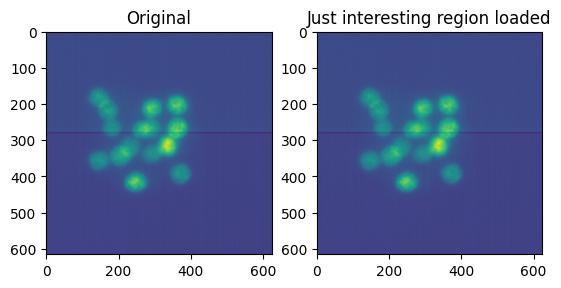

In [2]:
name_file = "example/0.tif" #Set

file_reader = sitk.ImageFileReader()
file_reader.SetFileName(name_file)
file_reader.ReadImageInformation() #Read infor without uploading file

#Set lims
xlims = (50,500)
ylims = (100,500)
zlims = (0,file_reader.GetSize()[2])

# read the image information without reading the bulk data, compute ROI start and size and read it.
start_index = (xlims[0],ylims[0],zlims[0])
extract_size = (xlims[1]-xlims[0],ylims[1]-ylims[0],zlims[1]-zlims[0])
# file_reader.SetExtractIndex(start_index)
# file_reader.SetExtractSize(extract_size)
# file_reader.SetOutputPixelType(sitk.sitkFloat32)

image_3D_original = sitk.ReadImage(name_file, sitk.sitkFloat32)

arr = sitk.GetArrayFromImage(image_3D_original)
image_3D = sitk.GetImageFromArray(arr[zlims[0]:zlims[1], ylims[0]:ylims[1], xlims[0]:xlims[1]])

fig,ax = plt.subplots(1,2)
ax[0].imshow(sitk.GetArrayFromImage(image_3D_original).sum(axis=0))
ax[0].set_title("Original")
ax[1].imshow(sitk.GetArrayFromImage(file_reader.Execute()).sum(axis=0))
ax[1].set_title("Just interesting region loaded")

Load image and set the appropiate spacing

In [3]:
# #Load the box region
# image_3D = file_reader.Execute()
# #Set physical space
# image_3D.SetSpacing([1,1,4]) #deltaX...
# image_3D.SetOrigin((0,0,0)) #origin of the image to rotate, transale etc.

Threshold background. This step may not be necessary but when performing rotations translations etc, then there are regions with all zeros. To make it homogeneous, I remove those pixels values to look it nicer.

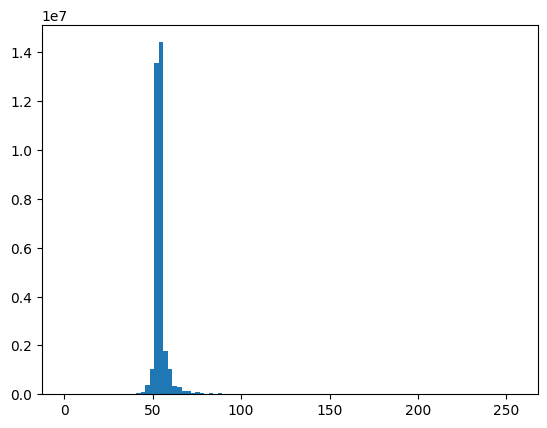

In [4]:
#to choose a threshold of the background noise
plt.hist(sitk.GetArrayFromImage(image_3D_original).flatten(),bins=100)
plt.show()

In [5]:
arr = sitk.GetArrayFromImage(image_3D_original)
image_3D_thresholded = sitk.GetImageFromArray(arr[zlims[0]:zlims[1], ylims[0]:ylims[1], xlims[0]:xlims[1]])
image_3D_thresholded.CopyInformation(image_3D) #use sampe parameters as the original figure
image_3D_thresholded[image_3D<70] = 0

image_3D_original_thresholded = sitk.ReadImage(name_file, sitk.sitkFloat32)
image_3D_original_thresholded.CopyInformation(image_3D_original)
image_3D_original_thresholded[image_3D_original<70] = 0


TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


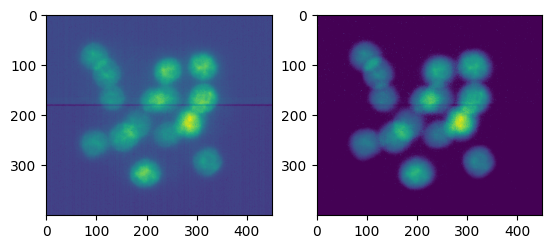

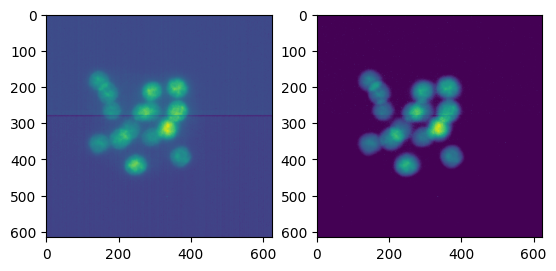

In [6]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(sitk.GetArrayFromImage(image_3D).sum(axis=0))
ax[1].imshow(sitk.GetArrayFromImage(image_3D_thresholded).sum(axis=0))

fig,ax = plt.subplots(1,2)

ax[0].imshow(sitk.GetArrayFromImage(image_3D_original).sum(axis=0))
ax[1].imshow(sitk.GetArrayFromImage(image_3D_original_thresholded).sum(axis=0))

# Transform

Make a random transformation.

In [7]:
rot_ax= (0,0,1)
rot_angle = 0.1*np.pi
trans = [0,10,0]

img_center = (image_3D_original_thresholded.GetHeight()/2,image_3D_original_thresholded.GetWidth()/2,image_3D_original_thresholded.GetDepth()/2)
#Rotation
transform = sitk.VersorTransform(rot_ax,rot_angle, img_center)
#Translation
transform2 = sitk.TranslationTransform(3,trans)
#Put together
transform_total = sitk.CompositeTransform([transform,transform2])
#Create image

image_3D_original_transformed = sitk.Resample(image_3D_original, transform_total)
image_3D_original_thresholded_transformed = sitk.Resample(image_3D_original_thresholded, transform_total)

arr = sitk.GetArrayFromImage(image_3D_original_transformed)
image_3D_transformed = sitk.GetImageFromArray(arr[zlims[0]:zlims[1], ylims[0]:ylims[1], xlims[0]:xlims[1]])

arr = sitk.GetArrayFromImage(image_3D_original_thresholded_transformed)
image_3D_thresholded_transformed = sitk.GetImageFromArray(arr[zlims[0]:zlims[1], ylims[0]:ylims[1], xlims[0]:xlims[1]])

Text(0.5, 1.0, 'thresholded and transformed')

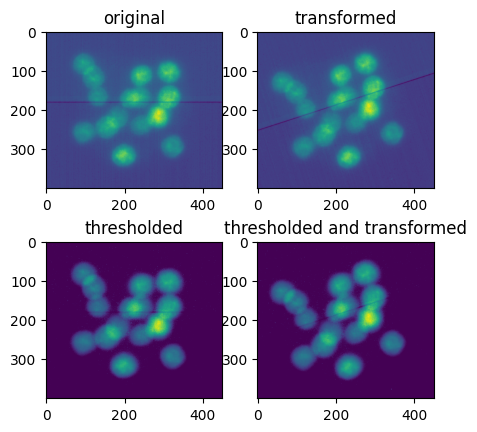

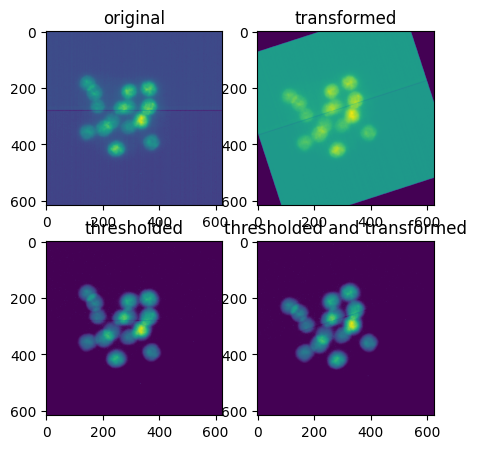

In [8]:
fig,ax = plt.subplots(2,2,figsize=(5,5))

ax[0,0].imshow(sitk.GetArrayFromImage(image_3D).sum(axis=0))
ax[0,0].set_title("original")
ax[0,1].imshow(sitk.GetArrayFromImage(image_3D_transformed).sum(axis=0))
ax[0,1].set_title("transformed")
ax[1,0].imshow(sitk.GetArrayFromImage(image_3D_thresholded).sum(axis=0))
ax[1,0].set_title("thresholded")
ax[1,1].imshow(sitk.GetArrayFromImage(image_3D_thresholded_transformed).sum(axis=0))
ax[1,1].set_title("thresholded and transformed")


fig,ax = plt.subplots(2,2,figsize=(5,5))

ax[0,0].imshow(sitk.GetArrayFromImage(image_3D_original).sum(axis=0))
ax[0,0].set_title("original")
ax[0,1].imshow(sitk.GetArrayFromImage(image_3D_original_transformed).sum(axis=0))
ax[0,1].set_title("transformed")
ax[1,0].imshow(sitk.GetArrayFromImage(image_3D_original_thresholded).sum(axis=0))
ax[1,0].set_title("thresholded")
ax[1,1].imshow(sitk.GetArrayFromImage(image_3D_original_thresholded_transformed).sum(axis=0))
ax[1,1].set_title("thresholded and transformed")

Registration

In [9]:
#Set what image is used as a reference and which is transformed
fixed_image = image_3D_thresholded

moving_image = image_3D_thresholded_transformed


In [10]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM) #NONE uses all pints, RANDOM downscales them
registration_method.SetMetricSamplingPercentage(0.01) #Percentage of downscaling

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=0.01,
    numberOfIterations=500,
    convergenceMinimumValue=1e-7,
    convergenceWindowSize=100,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

#Transform this initializer, 
# (If you do not put it, nothing happens, 
# I have to explore more what it does, I guess this specifies which transformation optimize (Euler3DTransform roations now)
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)
# Don't optimize in-place, we would possibly like to run this cell multiple times. 
registration_method.SetInitialTransform(initial_transform, inPlace=False)

#You can add something to plot during optimization
def f(registration_method):
    print("loss: ",registration_method.GetMetricValue())
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: f(registration_method)
)

# Run the fitting and get the transform
final_transform = registration_method.Execute(fixed_image, moving_image)

# Always check the reason optimization terminated.
print("Final metric value: {0}".format(registration_method.GetMetricValue()))
print(
    "Optimizer's stopping condition, {0}".format(
        registration_method.GetOptimizerStopConditionDescription()
    )
)

loss:  -0.059336612884172274
loss:  -0.06053141353772787
loss:  -0.06154649493208735
loss:  -0.06229612388230191
loss:  -0.06340339075078363
loss:  -0.06428424212085776
loss:  -0.0650441277202588
loss:  -0.06598656753828307
loss:  -0.06693104682531373
loss:  -0.06741532391268971
loss:  -0.06831260184056774
loss:  -0.06893874412356771
loss:  -0.07041323954347317
loss:  -0.07166880202270176
loss:  -0.07209208637097808
loss:  -0.07291516588790803
loss:  -0.07379676961720343
loss:  -0.074570567845209
loss:  -0.07545552141464357
loss:  -0.07649253111137366
loss:  -0.07726935902536236
loss:  -0.07842223490337137
loss:  -0.07940417136746449
loss:  -0.08071757302191598
loss:  -0.08203498037805293
loss:  -0.08308795620247082
loss:  -0.08437063731003686
loss:  -0.08539206994840744
loss:  -0.0864864763741409
loss:  -0.08741705128331399
loss:  -0.08881531564795428
loss:  -0.08925224595292715
loss:  -0.09073386236815124
loss:  -0.09196302451608306
loss:  -0.09356381603890565
loss:  -0.0948745724079

In [11]:
tr = sitk.CompositeTransform([final_transform])
image_3D_corrected = sitk.Resample(image_3D_thresholded_transformed, tr)
idxs = (-1*start_index[0], -1*start_index[1], -1*start_index[2])
image_3D_original_thresholded_transformed.SetOrigin((idxs))
image_3D_original_corrected = sitk.Resample(image_3D_original_thresholded_transformed, tr)

tr_real = transform_total.GetInverse()
idxs = (start_index[0], -1*start_index[1], -1*start_index[2])
image_3D_thresholded_transformed.SetOrigin((start_index))
image_3D_corrected_real = sitk.Resample(image_3D_thresholded_transformed, tr_real)
image_3D_original_thresholded_transformed.SetOrigin((0,0,0))
image_3D_original_corrected_real = sitk.Resample(image_3D_original_thresholded_transformed, tr_real)


Text(0.5, 1.0, 'R = Corrected real ; G = Original')

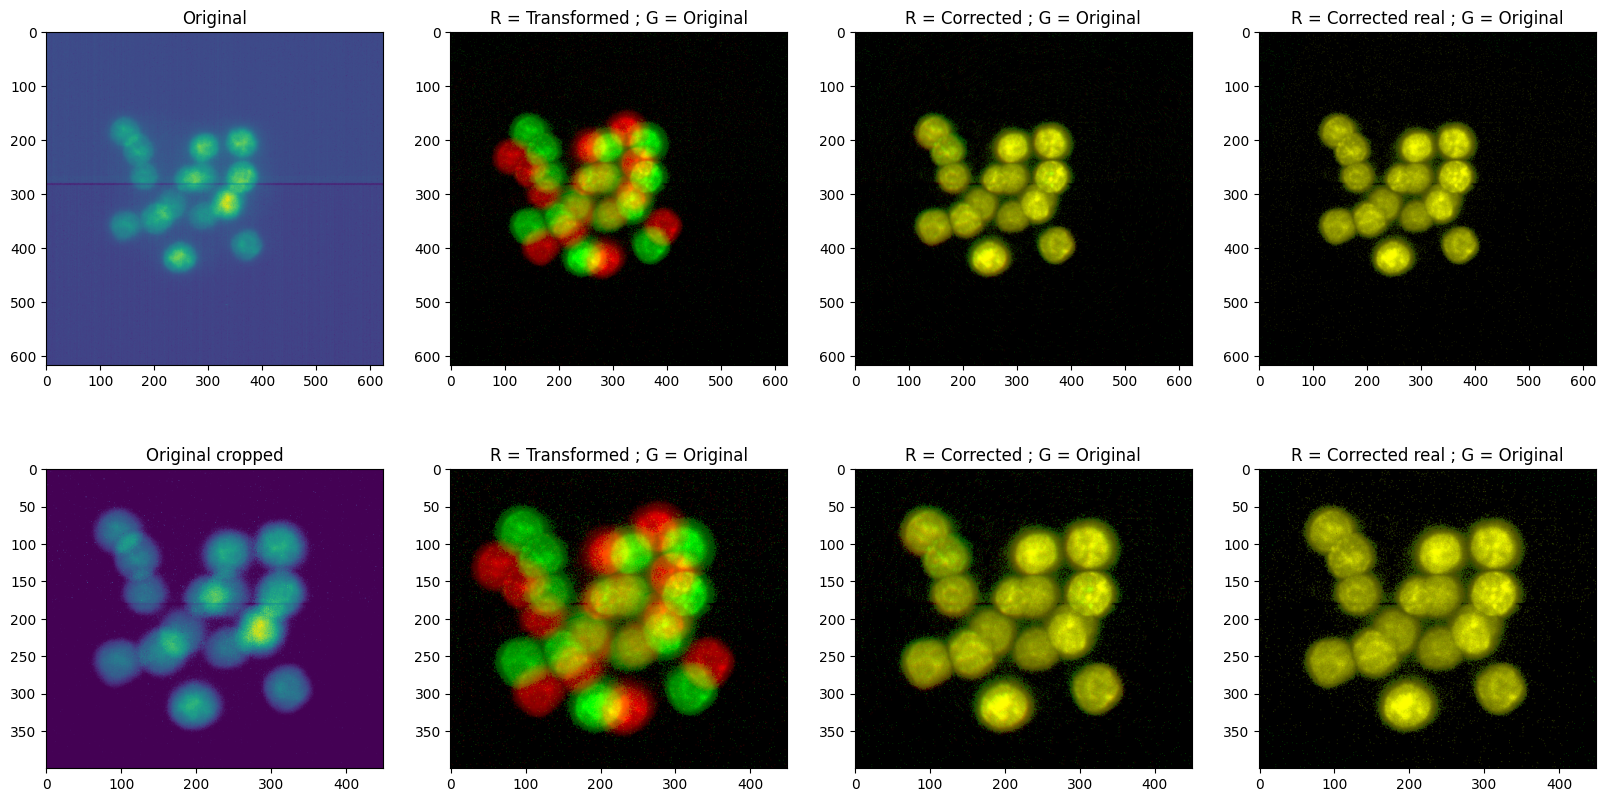

In [12]:
fig,ax = plt.subplots(2,4,figsize=(20,10))

from embdevtools import construct_RGB
ax[0,0].imshow(sitk.GetArrayFromImage(image_3D_original).sum(axis=0))
ax[0,0].set_title("Original")

arr1 = sitk.GetArrayFromImage(image_3D_original_thresholded_transformed)
arr2 = sitk.GetArrayFromImage(image_3D_original_thresholded)
IMGSRGB_trans = construct_RGB(R=np.max(arr1, axis=0)/255.0, G=np.max(arr2, axis=0)/255.0, B=None, order="XYC")
ax[0,1].imshow(IMGSRGB_trans)
ax[0,1].set_title("R = Transformed ; G = Original")

arr1 = sitk.GetArrayFromImage(image_3D_original_corrected)
arr2 = sitk.GetArrayFromImage(image_3D_original_thresholded)
IMGSRGB = construct_RGB(R=np.max(arr1, axis=0)/255.0, G=np.max(arr2, axis=0)/255.0, B=None, order="XYC")
ax[0,2].imshow(IMGSRGB)
ax[0,2].set_title("R = Corrected ; G = Original")

arr1 = sitk.GetArrayFromImage(image_3D_original_corrected_real)
arr2 = sitk.GetArrayFromImage(image_3D_original_thresholded)
IMGSRGB_real = construct_RGB(R=np.max(arr1, axis=0)/255.0, G=np.max(arr2, axis=0)/255.0, B=None, order="XYC")
ax[0,3].imshow(IMGSRGB_real)
ax[0,3].set_title("R = Corrected real ; G = Original")


ax[1,0].imshow(sitk.GetArrayFromImage(image_3D_thresholded).sum(axis=0))
ax[1,0].set_title("Original cropped")

arr1 = sitk.GetArrayFromImage(image_3D_thresholded_transformed)
arr2 = sitk.GetArrayFromImage(image_3D_thresholded)
IMGSRGB_cropped_trans = construct_RGB(R=np.max(arr1, axis=0)/255.0, G=np.max(arr2, axis=0)/255.0, B=None, order="XYC")
ax[1,1].imshow(IMGSRGB_cropped_trans)
ax[1,1].set_title("R = Transformed ; G = Original")


arr1 = sitk.GetArrayFromImage(image_3D_corrected)
arr2 = sitk.GetArrayFromImage(image_3D_thresholded)
IMGSRGB_cropped = construct_RGB(R=np.max(arr1, axis=0)/255.0, G=np.max(arr2, axis=0)/255.0, B=None, order="XYC")
ax[1,2].imshow(IMGSRGB_cropped)
ax[1,2].set_title("R = Corrected ; G = Original")

arr1 = sitk.GetArrayFromImage(image_3D_corrected_real)
arr2 = sitk.GetArrayFromImage(image_3D_thresholded)
IMGSRGB_cropped_real = construct_RGB(R=np.max(arr1, axis=0)/255.0, G=np.max(arr2, axis=0)/255.0, B=None, order="XYC")
ax[1,3].imshow(IMGSRGB_cropped_real)
ax[1,3].set_title("R = Grouthtruth ; G = Original")

